In [37]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ngsolve import CoefficientFunction
from ngsolve.meshes import MakeStructured2DMesh
import time

Hier wird eine lineare Funktion verwendet, um alle Werte von -1.5 bis 1.5 drin zu haben.

In [38]:
def fun(x):
    return x - 2

x = np.linspace(0,2,100)
fun_x = fun(x)

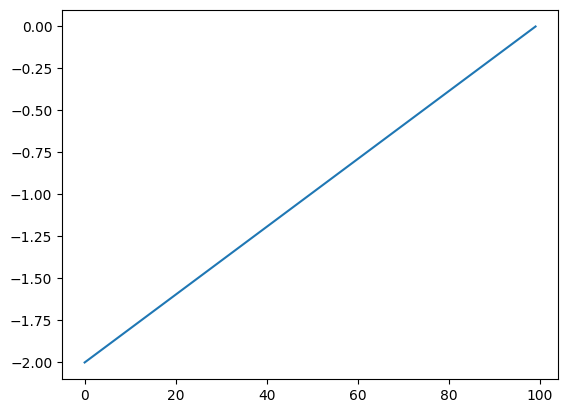

In [39]:
plt.plot(fun_x)
plt.show()

In [40]:
#print(fun_x)

In [41]:
# generate a 1D mesh
ngmesh = NGMesh()
ngmesh.dim = 1

nel = 1
l0 = 2

pnums = []
for i in range(0, nel+1):
    pnums.append (ngmesh.Add(MeshPoint (Pnt(i/nel*l0, 0, 0))))

for i in range(0,nel):
    ngmesh.Add (Element1D([pnums[i],pnums[i+1]], index=1))

ngmesh.Add (Element0D(pnums[0], index=1))
ngmesh.Add (Element0D(pnums[nel], index=2))

mesh = Mesh(ngmesh)

In [42]:
cf = VoxelCoefficient((0,0),(1,1),
                         fun_x[np.arange(fun_x.shape[0]-1,-1,-1)])

In [43]:
Draw(cf,mesh,'cf')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [44]:
# Startwerte:
t0 = 0
dt0 = 0.1
tend = 5
eps0 = 1e-4
d2t = 0.05  #Änderungsrate für dt

# Initialisierung der Parameter
t = Parameter (t0)
dt = Parameter (dt0)
eps = Parameter (eps0)

In [45]:
order = 2
V = H1(mesh, order=order, dirichlet=[1,2])
u = V.TrialFunction()
v = V.TestFunction()
gfu = GridFunction(V)

a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu)**2)*dx)

# Interpolate the function onto the finite element space
u0 = GridFunction(V)
u0.Set(fun)

# Set the initial condition on the GridFunction
gfu.Set(u0)

TypeError: Set(): incompatible function arguments. The following argument types are supported:
    1. (self: ngsolve.comp.GridFunction, coefficient: ngsolve.fem.CoefficientFunction, VOL_or_BND: ngsolve.comp.VorB = <VorB.VOL: 0>, definedon: object = <ngsolve.ngstd.DummyArgument>, dual: bool = False, use_simd: bool = True, mdcomp: int = 0, definedonelements: Optional[pyngcore.pyngcore.BitArray] = None, bonus_intorder: int = 0) -> None

Invoked with: <ngsolve.comp.GridFunction object at 0x10fdc0cb0>, <function fun at 0x10fde9120>

In [ ]:
res = gfu.vec.CreateVector()
du = gfu.vec.CreateVector()

# Newton Verfahren:
start_time = time.time()
for it in range(10000000):
    print("Newton iteration", it)

    # lösen des linearisierten Problems:
    # F(u_n)
    a.Apply (gfu.vec, res)

    # F'(u_n)
    a.AssembleLinearization(gfu.vec)

    #du.vec.data = a.mat.Inverse(V.FreeDofs(), inverse="umfpack") * res.vec
    #du.vec.data= a * res
    du.data = a.mat.Inverse(V.FreeDofs(), inverse="masterinverse") * res

    # update gfu
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    # eps für nächsten Zeitschritt updaten
    eps.Set(eps.Get() * 1e-2)
    print("eps:", eps.Get())

    # Aktuelle Zeit updaten
    t.Set(t.Get()+dt.Get())
    print("Seconds passed: ", t.Get())

    # Abbruchkriterium: nach 2 Sekunden (wie in Aufgabenstellung beschrieben)
    t += dt.Get()
    print(t)
    if t >= tend:
        break

    # dt für nächsten Schritt updaten
    dt.Set(dt.Get() + d2t)
    print("dt für nächste Iteration: ", dt.Get())

    # Abbruchkriterium: wenn es vor schon vor Ablauf der 2 Sekunden konvergiert
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}A0.S = ", stopcritval)
    print(gfu)
    if stopcritval < 1e-13:
        break

end_time = time.time()
time_to_compute = end_time - start_time

In [ ]:
Draw(gfu)

In [ ]:
def uexact(x):
    return x-2

In [ ]:
xi = np.linspace(0,2,100)
ui = [gfu(xip) for xip in xi]

plt.plot(xi,ui, label='FEM-Lösung')
plt.plot(xi,uexact(xi),'--',label='analytische Lösung')
plt.legend(loc=1)
plt.grid()
plt.show()